# **Sieć Bayesowska** (ang. *Bayesian Network*)
to probabilistyczny model grafowy, w którym zmienne losowe i ich warunkowe niezależności reprezentowane sa za pomocą **skierowanego acyklicznego grafu**.

# Warunkowa niezależność
**Przykład**:
Rozważmy model składający się z następujących zmiennych losowych:
- $\text{MIT}$ - akcpetacja studenta na MIT
- $\text{Stanford}$ - akceptacja studenta na Stanford

Pomimo, że zmienne dotyczą akceptacji na różne uczelnie, to nie możemy założyć, że są niezależne. Jeżeli student został zaakceptowany na MIT, to znaczy że ma bardzo dobre wyniki i są duże szanse, że dostanie się również na Stanford. 
$$ P(\text{MIT}, \text{Stanford}) \neq P(\text{MIT}) \cdot P(\text{Stanford}), $$
gdzie $P(\text{MIT})$ i $P(\text{Stanford})$ to funkcje masy prawdopobieństwa dla odpowiednich zmiennych.
Możemy wprowadzić dodatkową zmienną losową:
- $\text{GPA}$ - średnia ocen
i założyć, że akceptacja na studia zależy tylko od średniej studenta. Wtedy
$$ P(\text{MIT}, \text{Stanford} | \text{GPA}=A) = P(\text{MIT}| \text{GPA}=A) \cdot P(\text{Stanford}| \text{GPA}=A) $$
i w konsekwencji również między innymi
$$ P(\text{MIT} | \text{Stanford}=1, \text{GPA}=A) = P(\text{MIT} | \text{GPA}=A).$$

Mówimy, że $\text{MIT}$ jest **warunkowo niezależne** od $\text{Stanford}$ przy **danym**  $\text{GPA}$ i oznaczamy jako
$$ \text{MIT} \perp \text{Stanford} | \text{GPA}.$$

Wykorzystanie wiedzy (intuicji) o warunkowych niezależnościach w danej przestrzeni probabilistycznej umożliwi wyrażenie rozkładu łącznego za pomocą reguły łańcuchowej i w konsekwencji sieci bayesowskiej.

# Model

Rozważmy model dotyczący kandydata na studia wyższe w USA, czyli absolwenta szkoły wyższej. Jego aplikacja będzie oceniana na podstawie wyniku z testu kompetencji (**SAT**) oraz treści listu polecającego od nauczyciela (**Letter**). Podstawową cechą kandydata jest jego inteligencja (**Intelligence**), ale nauczyciel ocenia ją na podstawie oceny kończowej z jego kursu (**Grade**), na którą wpływa również trudność pytań zaliczeniowych (**Difficulty**).

Zdefiniumy poniżej zmienne występujące w modelu.

In [1]:
difficulty = 'Difficulty'
intelligence = 'Intelligence'
grade = 'Grade'
sat = 'SAT'
letter = 'Letter'

random_variables = [
    difficulty,
    intelligence,
    grade,
    sat,
    letter,
]

In [2]:
from scipy.special import binom

Ile jest Sieci Bayesowskich na tych zmiennych losowych?

In [3]:
def number_of_dags(n):
    '''Based on https://en.wikipedia.org/wiki/Directed_acyclic_graph#Combinatorial_enumeration'''
    def _internal(n_int, k):
        assert k <= n_int
        return ((-1)**(k-1)) * int(binom(n_int, k)) * (2**(k*(n_int - k))) * number_of_dags(n_int - k)
    if n == 0:
        return 1
    else:
        return sum([_internal(n, k) for k in range(1, n+1)])

In [4]:
number_of_dags(len(random_variables))

29281

Propozycja:

- **Difficulty** jest niezależne od pozostałych zmiennych, a jedynie na nie wpływa; poza modelem istnieją czynniki wpływające na trudność, ale ich nie obserwujemy
- **Intelligence** to kolejna zmienna, która jest niezależne od pozostałych, będzie natomiast na nie wpływać (pośrednio, bądź bezpośrednio)
- **Grade** jest bezpośrednio zależne od wyżej wymienionych czynników
- **SAT** (Scholastic Assessment Test) jest ustandaryzowanym egzaminem państwowym, więc jedynym co wpływa na wynik są umiejętności kandydata (w naszym modelu zawarte w zmiennej Intelligence)
- **Letter** to subiektywna ocena prowadzącego na temat ucznia, można się jednak spodziewać że nie jest ona wnikliwa, a jedynie oparta na ocenie z kursu.

Zapiszmy powyższe zależności w postaci grafu skierowanego.

In [5]:
from pgmpy.models import BayesianModel

# skierowany model!
bn = BayesianModel([
    (difficulty, grade),
    (intelligence, grade),
    (intelligence, sat),
    (grade, letter),
])

/usr/local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


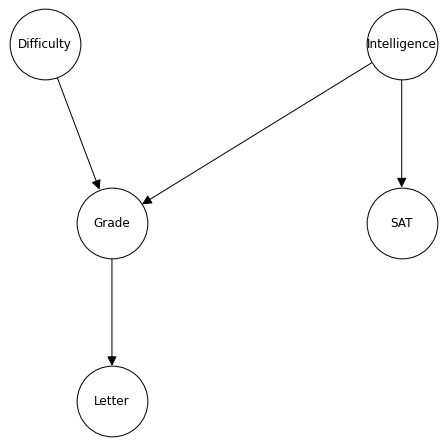

In [6]:
import networkx as nx
# requires graphviz and graphviz-dev installed in your operating system
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt

plt.figure(figsize=(6, 6))
pos=graphviz_layout(bn, prog='dot')
nx.draw(
    bn,
    pos=pos,
    with_labels=True,
    node_color='white',
    edgecolors='black',
    node_size=5000,
    arrowsize=20,
)
plt.show()

# D-separacja
Warunkowa niezależność jest podstawowym narzędziem we wnioskowaniu w Sieciach Bayesowskich - przy spełnieniu odpowidnich warunków pozwala faktoryzować rozkłady łączne w iloczyn rozkładów brzegowych. W skomplikowanych modelach probabilistycznych, gdzie dwa wierzchołki połączone są kilkoma ścieżkami identyfikacja waunkowych niezależność nie jest trywialna. Rozwiązaniem jest zaproponowanie **algorytmu D-separacji**.

Wprowadzenie do D-separacji: [http://web.mit.edu/jmn/www/6.034/d-separation.pdf](http://web.mit.edu/jmn/www/6.034/d-separation.pdf)

In [7]:
print(bn.is_active_trail(intelligence, letter))
print(bn.is_active_trail(intelligence, letter, observed=[grade]))

True
False


In [8]:
print(bn.is_active_trail(intelligence, difficulty))
print(bn.is_active_trail(intelligence, difficulty, observed=[grade]))

False
True


In [9]:
bn.active_trail_nodes(difficulty)

{'Difficulty': {'Difficulty', 'Grade', 'Letter'}}

In [10]:
bn.active_trail_nodes(difficulty, observed=[grade])

{'Difficulty': {'Difficulty', 'Intelligence', 'SAT'}}

In [11]:
bn.local_independencies(difficulty)

(Difficulty ⟂ Intelligence, SAT)

In [12]:
bn.local_independencies(letter)

(Letter ⟂ Intelligence, SAT, Difficulty | Grade)

In [13]:
bn.get_independencies()

(Difficulty ⟂ Intelligence, SAT)
(Difficulty ⟂ SAT | Intelligence)
(Difficulty ⟂ Intelligence | SAT)
(Difficulty ⟂ Letter | Grade)
(Difficulty ⟂ SAT | Intelligence, Letter)
(Difficulty ⟂ Letter, SAT | Intelligence, Grade)
(Difficulty ⟂ Letter | SAT, Grade)
(Difficulty ⟂ SAT | Intelligence, Letter, Grade)
(Difficulty ⟂ Letter | Intelligence, SAT, Grade)
(Grade ⟂ SAT | Intelligence)
(Grade ⟂ SAT | Intelligence, Letter)
(Grade ⟂ SAT | Intelligence, Difficulty)
(Grade ⟂ SAT | Intelligence, Letter, Difficulty)
(Intelligence ⟂ Difficulty)
(Intelligence ⟂ Difficulty | SAT)
(Intelligence ⟂ Letter | Grade)
(Intelligence ⟂ Letter | SAT, Grade)
(Intelligence ⟂ Letter | Difficulty, Grade)
(Intelligence ⟂ Letter | SAT, Difficulty, Grade)
(SAT ⟂ Difficulty)
(SAT ⟂ Letter, Difficulty, Grade | Intelligence)
(SAT ⟂ Letter | Grade)
(SAT ⟂ Difficulty, Grade | Intelligence, Letter)
(SAT ⟂ Letter, Grade | Intelligence, Difficulty)
(SAT ⟂ Letter, Difficulty | Intelligence, Grade)
(SAT ⟂ Letter | Difficulty,

# Tabularyczny Warunkowy Rozkład Prawdopobieństwa
Warunkowe rozkłady na zmiennych dyskretnych możemy zapisać za pomocą tabeli, tworząc Tabularyczny Warunkowy Rozkład Prawdopobieństwa. Jest to podstawowy rodzaj rozkładu w pgmpy.

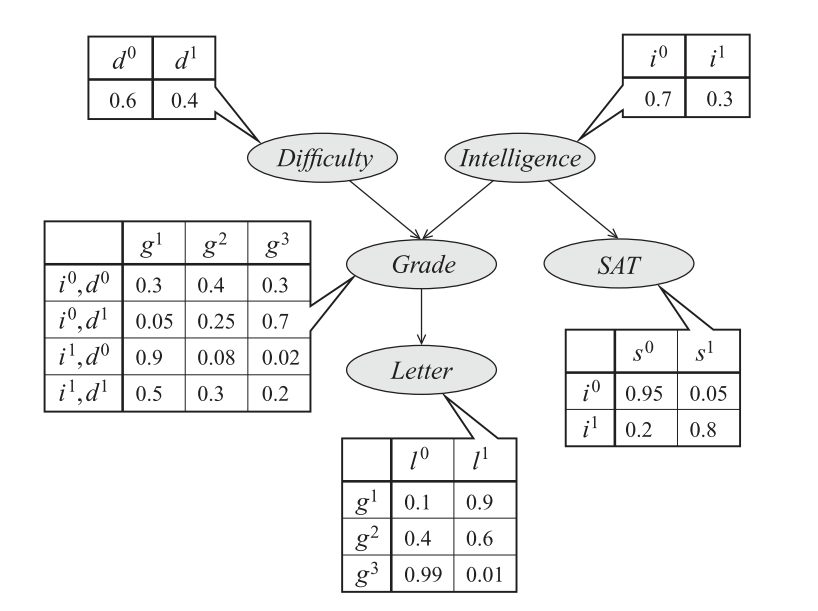

In [14]:
from IPython.display import Image
Image('figures/SAT_bayesian_network.png')
# Source: Koller, D., & Friedman, N. (2015). Probabilistic graphical models. In Studies in Systems, Decision and Control (Vol. 11). https://doi.org/10.1007/978-3-319-11325-8_2 Fig. 3.4

In [15]:
from pgmpy.factors.discrete import TabularCPD

From https://pgmpy.org/_modules/pgmpy/factors/discrete/CPD.html:

For a distribution of P(grade|diff, intel):

    |diff    |      easy          |    hard          |
    | ----- | --- | ---- | ----- | ---- | -- | ---- |
    |intel  |dumb |  avg | smart | dumb |avg |smart |
    |gradeA |0.1  |  0.1 |  0.1  | 0.1  |0.1 | 0.1  |
    |gradeB |0.1  |  0.1 |  0.1  | 0.1  |0.1 | 0.1  |
    |gradeC |0.8  |  0.8 |  0.8  | 0.8  |0.8 | 0.8  |

values should be:

    [[0.1,0.1,0.1,0.1,0.1,0.1],
    [0.1,0.1,0.1,0.1,0.1,0.1],
    [0.8,0.8,0.8,0.8,0.8,0.8]]

In [16]:
cpds = {
    difficulty: TabularCPD(
        variable=difficulty,
        variable_card=2,
        values=[[0.6], [0.4]]
    ),
    intelligence: TabularCPD(
        variable=intelligence,
        variable_card=2,
        values=[[0.7], [0.3]]
    ),
    grade: TabularCPD(
        variable=grade,
        variable_card=3,
        evidence=[difficulty, intelligence],
        evidence_card=[2, 2],
        values=[
            [0.3, 0.9, 0.05, 0.5],
            [0.4, 0.08, 0.25, 0.3],
            [0.3, 0.02, 0.7, 0.2],
        ]
    ),
    sat: TabularCPD(
        variable=sat,
        variable_card=2,
        evidence=[intelligence],
        evidence_card=[2],
        values=[
            [0.95, 0.2],
            [0.05, 0.8],
        ]
    ),
    letter: TabularCPD(
        variable=letter,
        variable_card=2,
        evidence=[grade],
        evidence_card=[3],
        values=[
            [0.1, 0.4, 0.99],
            [0.9, 0.6, 0.01],
        ]
    )
    
}

In [17]:
# Associating the parameters with the model structure.
bn.add_cpds(*cpds.values())

# Checking if the cpds are valid for the model.
bn.check_model()

True

# Wnioskowanie w sieciach bayesowskich
Zastosowaniem dla probabilistycznych modeli grafowych jest **wnioskowanie**, czyli odpowiadanie na **zapytania** na podstawie łącznego rozkładu prawdopobieństwa. Wyszczególnić można dwa podstawowe typy zapytań:
1. Zapytanie o rozkład

   Celem jest odnaleźć (obliczyć)
   $$ P(Y | E=e),$$
   gdzie $E$ to podzbiór obserwowanych zmiennych o wartościach $e$, a $Y$ to podzbiór zmiennych dla których szukamy rozkładu posterior. Model może składać się z większej liczby zmiennych niż $Y$ i $E$, które należy zmarginalizować w tym zapytaniu.
   
2. Zapytanie o najbardziej prawdopodobną wartość

   Niech $W = X - E$, gdzie $X$ to zbiór wszystkich zmiennych w modelu, a $E$ to zbiór zmiennych obserwowanych o wartościach $e$. Zapytanie to:
   $$ MAP(W | E=e) = \arg \max_w P(W=w, E=e).$$
   
Należy zwrócić uwagę na różnicę pomiędzy tymi dwoma rodzajami zapytań. W 2. pytamy o najbardziej prawdopodobną konfigurajcę całego modelu przy obserwacji $e$. Natomiast 1. dotyczy rozkładu (na podstawie, którego łatwo możemy obliczyć MAP) łącznego podzbioru zmiennych w sieci przy obserwacji $e$, gdzie pozostałe elementy modelu zostają wymarginalizowane.

In [18]:
from pgmpy.inference import VariableElimination, BeliefPropagation

Dwie metody do wnioskowanie *dokładnego*:
- Variable Elimination
- Belief Propagation

In [19]:
ve_infer = VariableElimination(bn)
bp_infer = BeliefPropagation(bn)

Jaki jest rozkład brzegowy `sat` gdy `grade=1`?

In [20]:
print(ve_infer.query(variables=[sat], evidence={grade: 1}))
print(bp_infer.query(variables=[sat], evidence={grade: 1}))

Eliminating: Difficulty: 100%|██████████| 3/3 [00:00<00:00, 504.87it/s]

+--------+------------+
| SAT    |   phi(SAT) |
+========+============+
| SAT(0) |     0.8189 |
+--------+------------+
| SAT(1) |     0.1811 |
+--------+------------+
+--------+------------+
| SAT    |   phi(SAT) |
+========+============+
| SAT(0) |     0.8189 |
+--------+------------+
| SAT(1) |     0.1811 |
+--------+------------+


Jaki jest rozkład łączny `sat` i `letter` gdy `grade=1`?

In [21]:
print(ve_infer.query(variables=[sat, letter], evidence={grade: 1}, joint=True))
# print(bp_infer.query(variables=[sat, letter], evidence={grade: 1}, joint=True))

Eliminating: Intelligence: 100%|██████████| 2/2 [00:00<00:00, 850.00it/s]

+--------+-----------+-------------------+
| SAT    | Letter    |   phi(SAT,Letter) |
+========+===========+===================+
| SAT(0) | Letter(0) |            0.3276 |
+--------+-----------+-------------------+
| SAT(0) | Letter(1) |            0.4914 |
+--------+-----------+-------------------+
| SAT(1) | Letter(0) |            0.0724 |
+--------+-----------+-------------------+
| SAT(1) | Letter(1) |            0.1086 |
+--------+-----------+-------------------+


Jaki jest rozkład brzegowy listy zmiennych gdy `grade=1`?

In [22]:
for f, pd in ve_infer.query(variables=[sat, letter], evidence={grade: 1}, joint=False).items():
    print(pd)

Eliminating: Intelligence: 100%|██████████| 2/2 [00:00<00:00, 436.77it/s]

+--------+------------+
| SAT    |   phi(SAT) |
+========+============+
| SAT(0) |     0.8189 |
+--------+------------+
| SAT(1) |     0.1811 |
+--------+------------+
+-----------+---------------+
| Letter    |   phi(Letter) |
+===========+===============+
| Letter(0) |        0.4000 |
+-----------+---------------+
| Letter(1) |        0.6000 |
+-----------+---------------+


Jaka jest najbardziej prawdopodobna konfiguracja gdy `intelligence=0`?

In [23]:
ve_infer.map_query(evidence={intelligence: 0})

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


{'Letter': 0, 'Grade': 2, 'SAT': 0, 'Difficulty': 1}

In [24]:
ve_infer.map_query(variables=[sat], evidence={intelligence: 0})

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


{'SAT': 0}

Jakie jest prawdopobieństwo takiego zdarzenia?

In [25]:
ve_infer.max_marginal(variables=[letter, grade, sat, difficulty], evidence={intelligence: 0})

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


0.26334

# Ale skąd CPDs w rzeczywistości? Z danych!

Na początek wygenerujmy zbiór danych na podstawie modelu ze znanymi rozkładami.

In [26]:
from pgmpy.sampling import BayesianModelSampling

In [27]:
df = BayesianModelSampling(bn).forward_sample(size=10_000)
df.head()

Generating for node: Letter: 100%|██████████| 5/5 [00:00<00:00, 34.92it/s]


,Intelligence,SAT,Difficulty,Grade,Letter
0,0,0,1,2,0
1,0,0,1,1,1
2,0,1,1,2,0
3,0,0,0,1,1
4,1,0,1,2,0


Stwórzmy nowy model o tej samej strukturze, jak poprzedni.

In [28]:
new_bn = BayesianModel(ebunch=bn.edges())
new_bn.nodes()

NodeView(('Difficulty', 'Grade', 'Letter', 'Intelligence', 'SAT'))

In [29]:
new_bn.get_cpds()

[]

Dostępne estymatory:
- Maximum Likelihood Estimator
- Bayesian Estimator

In [30]:
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

MLE nie ma żadnych parametrów.

In [31]:
mle = MaximumLikelihoodEstimator(model=new_bn, data=df)
print(mle.estimate_cpd(node=intelligence))

+-----------------+--------+
| Intelligence(0) | 0.7003 |
+-----------------+--------+
| Intelligence(1) | 0.2997 |
+-----------------+--------+


CPDs dla wszystkich wierzchołków.

In [32]:
mle.get_parameters()

[<TabularCPD representing P(Difficulty:2) at 0x7f711f2ba850>,
 <TabularCPD representing P(Grade:3 | Difficulty:2, Intelligence:2) at 0x7f711f2ba4c0>,
 <TabularCPD representing P(Intelligence:2) at 0x7f711f2ba6a0>,
 <TabularCPD representing P(Letter:2 | Grade:3) at 0x7f711f2ba580>,
 <TabularCPD representing P(SAT:2 | Intelligence:2) at 0x7f711f24caf0>]

Dla Bayesian Estimator musimy określić prior:
>        prior_type: 'dirichlet', 'BDeu', or 'K2' string indicting which type of prior to use for the model parameters.
            - If 'prior_type' is 'dirichlet', the following must be provided:
                'pseudo_counts' = dirichlet hyperparameters; a single number or a dict containing, for each
                 variable, a 2-D array of the shape (node_card, product of parents_card) with a "virtual"
                 count for each variable state in the CPD, that is added to the state counts.
                 (lexicographic ordering of states assumed)
            - If 'prior_type' is 'BDeu', then an 'equivalent_sample_size'
                must be specified instead of 'pseudo_counts'. This is equivalent to
                'prior_type=dirichlet' and using uniform 'pseudo_counts' of
                `equivalent_sample_size/(node_cardinality*np.prod(parents_cardinalities))` for each node.
                'equivalent_sample_size' can either be a numerical value or a dict that specifies
                the size for each variable separately.
            - A prior_type of 'K2' is a shorthand for 'dirichlet' + setting every pseudo_count to 1,
                regardless of the cardinality of the variable.

In [33]:
be = BayesianEstimator(new_bn, df)
print(be.estimate_cpd(
    node=intelligence,
    prior_type='dirichlet',
    pseudo_counts=2
))

+-----------------+---------+
| Intelligence(0) | 0.70022 |
+-----------------+---------+
| Intelligence(1) | 0.29978 |
+-----------------+---------+


In [34]:
print(be.estimate_cpd(
    node=intelligence,
    prior_type='BDeu',
    equivalent_sample_size=5,
))

+-----------------+--------+
| Intelligence(0) | 0.7002 |
+-----------------+--------+
| Intelligence(1) | 0.2998 |
+-----------------+--------+


Możemy też zastosować metodę `fit` na modelu by uzyskać CPD przypisane do odpowiednich zmiennych.

In [35]:
new_bn.fit(data=df, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=2)
new_bn.get_cpds()

[<TabularCPD representing P(Difficulty:2) at 0x7f711f1fbbe0>,
 <TabularCPD representing P(Grade:3 | Difficulty:2, Intelligence:2) at 0x7f711f1fba00>,
 <TabularCPD representing P(Letter:2 | Grade:3) at 0x7f711f1fbc10>,
 <TabularCPD representing P(Intelligence:2) at 0x7f711f1fbdc0>,
 <TabularCPD representing P(SAT:2 | Intelligence:2) at 0x7f711f1fb9d0>]

# A skąd struktura modelu? Z danych!

W pakiecie pgmpy zaimplementowane są następujące algorytmy do uczenia struktury Sieci Bayesowskich:
1. Struktura drzewiasta:
   1. Tree-augmented Naive Bayes - [pgmpy.estimators.TreeSearch](http://pgmpy.org/estimators.html#pgmpy.estimators.TreeSearch)
   2. Chow-Liu algorithm - [pgmpy.estimators.TreeSearch](http://pgmpy.org/estimators.html#pgmpy.estimators.TreeSearch)
2. Struktura DAG:
   * score-based:
       1. Przegląd zupełny - [pgmpy.estimators.ExhaustiveSearch](http://pgmpy.org/estimators.html#pgmpy.estimators.ExhaustiveSearch)
       2. Tabu Search - [pgmpy.estimators.HillClimbSearch](http://pgmpy.org/estimators.html#pgmpy.estimators.HillClimbSearch)
   * constraint-based:
       3. Algorytm PC z ograniczeniami - [pgmpy.estimators.PC](http://pgmpy.org/estimators.html#)
   * podejście hybrydowe:
       4. MMHC (Max-Min [Local-to-Global Learner with] Hill Climbing) - [pgmpy.estimators.MmhcEstimator](http://pgmpy.org/estimators.html#pgmpy.estimators.MmhcEstimator)
   
W przypadku `ExhaustiveSearch` oraz `HillClimbSearch` musimy określić funkcję oceniającą dopasowanie struktury do danych - `scoring_method`. W pakiecie zaimplementowane są następujące funkcje:
1. BDeu Score - [pgmpy.estimators.BDeuScore](http://pgmpy.org/estimators.html#pgmpy.estimators.BDeuScore)
2. Bic Score - [pgmpy.estimators.BicScore](http://pgmpy.org/estimators.html#pgmpy.estimators.BicScore)
3. K2 Score - [pgmpy.estimators.K2Score](http://pgmpy.org/estimators.html#pgmpy.estimators.K2Score)

Ponadto istnieje możliwość implementacji własnych metod dziedziczących po klasie [pgmpy.estimators.StructureScore](http://pgmpy.org/estimators.html#pgmpy.estimators.StructureScore).

#### Ewaluacja struktury
Posiadając rzeczywistą strukturę referncyjną możemy obliczyć jakość wyuczonego modelu jako miara F1 namaceirzy sąsiedztwa grafu.

In [36]:
from sklearn.metrics import f1_score
import numpy as np
def get_f1_score(estimated_model, true_model):
    nodes = estimated_model.nodes()
    est_adj = nx.to_numpy_matrix(estimated_model.to_undirected(), nodelist=nodes, weight=None)
    true_adj = nx.to_numpy_matrix(true_model.to_undirected(), nodelist=nodes, weight=None)
    
    return f1_score(np.ravel(true_adj), np.ravel(est_adj))

#### Przegląd zupełny
Dla zbiorów danych powyżej 6 zmiennych będzie trwać bardzo długo.

In [37]:
from pgmpy.estimators import ExhaustiveSearch, K2Score
get_f1_score(
    ExhaustiveSearch(df, scoring_method=K2Score(df)).estimate(),
    bn,
)

1.0

#### Tabu Search

Opis parametrów metody `estimate`:
>        scoring_method: str or StructureScore instance
            The score to be optimized during structure estimation.  Supported
            structure scores: k2score, bdeuscore, bicscore. Also accepts a
            custom score but it should be an instance of `StructureScore`.
>        start_dag: DAG instance
            The starting point for the local search. By default a completely
            disconnected network is used.
>        fixed_edges: iterable
            A list of edges that will always be there in the final learned model.
            The algorithm will add these edges at the start of the algorithm and
            will never change it.
>        tabu_length: int
            If provided, the last `tabu_length` graph modifications cannot be reversed
            during the search procedure. This serves to enforce a wider exploration
            of the search space. Default value: 100.
>        max_indegree: int or None
            If provided and unequal None, the procedure only searches among models
            where all nodes have at most `max_indegree` parents. Defaults to None.
>        black_list: list or None
            If a list of edges is provided as `black_list`, they are excluded from the search
            and the resulting model will not contain any of those edges. Default: None
>        white_list: list or None
            If a list of edges is provided as `white_list`, the search is limited to those
            edges. The resulting model will then only contain edges that are in `white_list`.
            Default: None
>        epsilon: float (default: 1e-4)
            Defines the exit condition. If the improvement in score is less than `epsilon`,
            the learned model is returned.
>        max_iter: int (default: 1e6)
            The maximum number of iterations allowed. Returns the learned model when the
            number of iterations is greater than `max_iter`.

In [38]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.base import DAG

start_dag = DAG()
start_dag.add_nodes_from(bn)
start_dag.add_edge(sat, letter)
get_f1_score(
    HillClimbSearch(df).estimate(
        scoring_method=K2Score(df),
        start_dag=start_dag,
    ),
    bn,
)

  0%|          | 5/1000000 [00:00<23:53:07, 11.63it/s]


1.0

#### Algorytm PC
Referencje:
1. Spirtes, P., Glymour, C., & Scheines, R. (2000). Causation, prediction, and search, 2nd edition. In Journal of Marketing Research (Vol. 39, Issue 1). p.84 Sec. 5.4.2 The PC Algorithm
2. Colombo, Diego, and Marloes H. Maathuis. "Order-independent constraint-based causal structure learning." J. Mach. Learn. Res. 15.1 (2014): 3741-3782.
3. Le, Thuc Duy, et al. "A fast PC algorithm for high dimensional causal discovery with multi-core PCs." IEEE/ACM transactions on computational biology and bioinformatics 16.5 (2016): 1483-1495.
4. Neapolitan, Richard E. Learning bayesian networks. Vol. 38. Upper Saddle River, NJ: Pearson Prentice Hall, 2004. p.550 Sec. 10.1.2 Algorithms for Determining DAG patterns Algorithm 10.2

Metoda ta buduje DAG na podstawie zbioru niezależności warunkowych pomiędzy zmiennymi. Są one identyfikowane za pomocą testów statystycznych. Alternatywnie użytkownik może ręcznie podać zbiór niezależności.

W ogólności metoda posiada trzy kroki:
1. Identyfikacja niezależności
2. Budowanie *szkieletu* - grafu z nieskierowanymi krawędziami
3. Ustalenie orientacji krawędzi

##### Testy na warunkową niezależność - [Conditional Independence Tests for PC algorithm](http://pgmpy.org/citests.html#module-pgmpy.estimators.CITests)

We wszystkich testach hipoteza zerowa to $$X \perp Y | Z$$

Obecnie dostępne są następujące testy:

- `chi_square`
- `cressie_read`
- `freeman_tuckey`
- `g_sq`
- `independence_match`
- `log_likelihood`
- `modified_log_likelihood`
- `neyman`
- `pearsonr`
- `power_divergence`

In [39]:
from pgmpy.estimators.CITests import chi_square

In [40]:
dict(zip(
    ('test_statistics', 'degrees-of-freedom', 'p-value'),
    chi_square(X=letter, Y=intelligence, Z=[grade], data=df, boolean=False)
))

{'test_statistics': 1.8372668685720996,
 'degrees-of-freedom': 3,
 'p-value': 0.6068590197622192}

In [41]:
chi_square(X=letter, Y=intelligence, Z=[grade], data=df, boolean=True, significance_level=0.05)

True

Za pomocą metody `build_skeleton` z klasy `PC` możemy wykonać odpowiedni zestaw testów i zbudować szkielet modelu. Klasa `PC` posiada następujące parametry:
- `data` - zbiór danych
- `independencies=None` - zbiór ręcznie zdefiniowanych warunkowych niezależności

Metoda `build_skeleton` posiada następujące parametry:
- `ci_test="chi_square"` - rodzaj testu w postaci `str` ("chi_square", "pearsonr" bądź "independence_match") albo funkcji
- `max_cond_vars=5` - maksymalny rozmiar zbioru zmiennych warunkująych Z
- `significance_level=0.01` - poziom istotności dla testów
- `variant="stable"` - wariant algorytmu ("orig", "stable", "parallel")
- `n_jobs=-1` - liczba wątków dla wariantu "parallel"
- `show_progress=True`

In [42]:
from pgmpy.estimators import PC

In [43]:
pc_est = PC(data=df)
skeleton, separating_sets = pc_est.build_skeleton(variant='parallel')

Working for n conditional variables: 4:  80%|████████  | 4/5 [00:00<00:00,  8.77it/s]


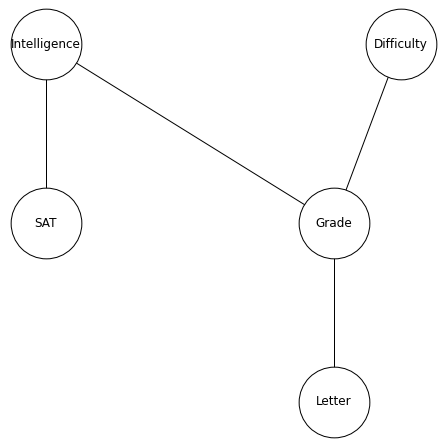

In [44]:
plt.figure(figsize=(6, 6))
pos=graphviz_layout(skeleton, prog='dot')
nx.draw(
    skeleton,
    pos=pos,
    with_labels=True,
    node_color='white',
    edgecolors='black',
    node_size=5000,
    arrowsize=10,
)
plt.xlim(min(list(map(lambda v: v[0], pos.values())))-15, max(list(map(lambda v: v[0], pos.values())))+15)
plt.ylim(min(list(map(lambda v: v[1], pos.values())))-15, max(list(map(lambda v: v[1], pos.values())))+15)
plt.show()

`separating_sets` to słownik zbiorów separujących dla każdej z nieistniejących krawędzi. Na jego podstawie ustalony będzie kierunek krawędzi.

Jeżeli zbiór separujący jest pusty, to zmienne są niezależne - a nie niezależne warunkowo.

In [45]:
separating_sets

{frozenset({'Difficulty', 'Intelligence'}): (),
 frozenset({'Difficulty', 'SAT'}): (),
 frozenset({'Intelligence', 'Letter'}): ('Grade',),
 frozenset({'Grade', 'SAT'}): ('Intelligence',),
 frozenset({'Letter', 'SAT'}): ('Intelligence',),
 frozenset({'Difficulty', 'Letter'}): ('Grade',)}

Kolejny krok to tranformacja szkieletu w częściowo skierowany acykliczny graf - PDAG. Partially Directed Acyclic Graphs stanowią klasy równoważności dla DAGów względem `separating_sets` na szkielecie.

In [46]:
pdag = pc_est.skeleton_to_pdag(skeleton, separating_sets)

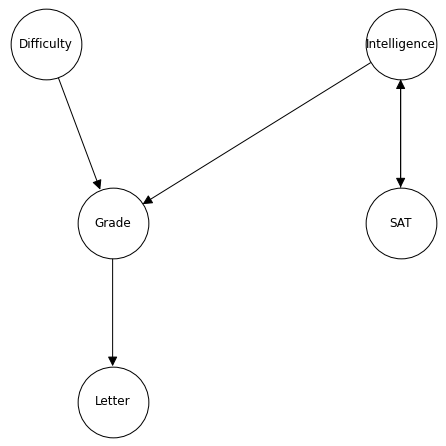

In [47]:
plt.figure(figsize=(6, 6))
pos=graphviz_layout(pdag, prog='dot')
nx.draw(
    pdag,
    pos=pos,
    with_labels=True,
    node_color='white',
    edgecolors='black',
    node_size=5000,
    arrowsize=20,
)
plt.xlim(min(list(map(lambda v: v[0], pos.values())))-15, max(list(map(lambda v: v[0], pos.values())))+15)
plt.ylim(min(list(map(lambda v: v[1], pos.values())))-15, max(list(map(lambda v: v[1], pos.values())))+15)
plt.show()

Ponieważ PDAG ustanawia klasę równoważności, to za finalny model możemy wybrać jakikolwiek DAG bazujący na powyższym PDAG. Służy do tego metoda `to_dag()`. Posiada ona argument `required_edges`, za pomocą którego możemy określić, które krawędzie muszą pojawić się w wyjściowym grafie. Taka operacje ma oczywiście wyłącznie sens dla krawędzi, które występują w obu stronach w PDAG.

UWAGA: Okazuje się, że w obecnej wersji biblioteki argument `required_edges` nie jest wykorzystany!

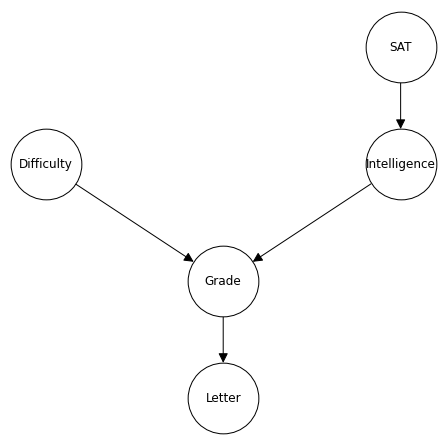

In [48]:
plt.figure(figsize=(6, 6))
pc_learned_model = pdag.to_dag()

pos=graphviz_layout(pc_learned_model, prog='dot')
nx.draw(
    pc_learned_model,
    pos=pos,
    with_labels=True,
    node_color='white',
    edgecolors='black',
    node_size=5000,
    arrowsize=20,
)
plt.xlim(min(list(map(lambda v: v[0], pos.values())))-15, max(list(map(lambda v: v[0], pos.values())))+15)
plt.ylim(min(list(map(lambda v: v[1], pos.values())))-25, max(list(map(lambda v: v[1], pos.values())))+25)
plt.show()

Widzimy, że domyślny DAG (bez wyspecyfikowania krawędzi do zachowania) nie zgadza się z oryginalnym modelem - występuje krawędź SAT -> Intelligence zamiast Intelligence -> SAT.

Ta sytuacja pokazuje, że na ostatnim kroku metody PC powinniśmy przeanalizować otrzymany PDAG i w miarę możliwości dokonać ręcznego ukierunkowania krawędzi.

Gdyby argument `required_edges` był wykorzystywany, dodalibyśmy tutaj krawędź Intelligence -> SAT jako wymaganą.

Powyższa procedura składa sie z kroków, które zostały zebrane jako metoda `estimate` klasy `PC`. Ma ona sygnaturę tożsamą z `build_skeleton` z dodatkowym argumentem `return_type`, który przyjmuje wartości `"dag"` (domyślnie) bądź `"pdag"` i specyfikuje jakiego typu modelu oczekujemy na wyjściu metody.

In [49]:
pc_learned_model_auto = pc_est.estimate(variant='parallel')

Working for n conditional variables: 4:  80%|████████  | 4/5 [00:00<00:00,  9.18it/s]


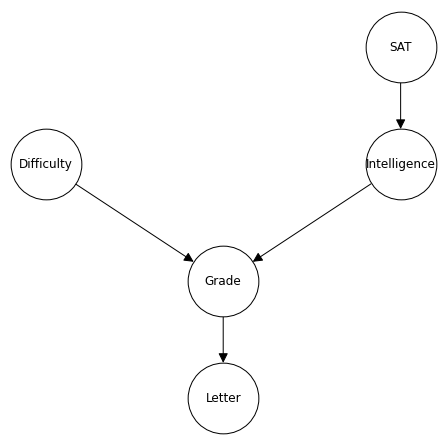

In [50]:
plt.figure(figsize=(6, 6))

pos=graphviz_layout(pc_learned_model_auto, prog='dot')
nx.draw(
    pc_learned_model_auto,
    pos=pos,
    with_labels=True,
    node_color='white',
    edgecolors='black',
    node_size=5000,
    arrowsize=20,
)
plt.xlim(min(list(map(lambda v: v[0], pos.values())))-15, max(list(map(lambda v: v[0], pos.values())))+15)
plt.ylim(min(list(map(lambda v: v[1], pos.values())))-25, max(list(map(lambda v: v[1], pos.values())))+25)
plt.show()

Na tak otrzymanym modelu należy dokonać estymacji warunkowych rozkładów prawdopobieństwa.

#### Podejście hybrydowe MMHC
Tsamardinos, I., Brown, L. E., & Aliferis, C. F. (2006). The max-min hill-climbing Bayesian network structure learning algorithm. Machine Learning, 65(1), 31–78. https://doi.org/10.1007/s10994-006-6889-7

Metoda polega na:
1. Identyfikacji nieskierowanego szkieletu

   W tym celu wykorzystana jest technika podobna jak PC (opiera się na testach statystycznych na warunkową niezależność). Autorzy twierdzą, że ich podejście działa efektywniej niż PC, ponieważ wymaga wykonania mniejszej ilości testów - jest to korzystne także ze względu na wielokrotne testowanie (ang. *Multiple comparisons problem*).
   
2. Zorientowania krawędzi z wykorzystaniem metody score-based

   Krawędzie ze szkieletu (czyli skierowane w obie strony) są wykorzystane jako white-list dla metody Tabu Search.

Analogiczną metodę można samemu stworzyć wykorzystując pierwszą część algorytmu PC oraz dowolną metodę score-based.

In [51]:
from pgmpy.estimators import MmhcEstimator, BDeuScore

In [52]:
mmhc_est = MmhcEstimator(data=df)

In [53]:
mmhc_learned_model = mmhc_est.estimate(scoring_method=BDeuScore(data=df), tabu_length=100, significance_level=0.01)

# ręczna implementacja dwóch kroków
# mmpc_skleton = mmhc_est.mmpc(significance_level=0.01)
# hc = HillClimbSearch(data=df, scoring_method=BDeuScore(data=df))
# mmhc_learned_model = hc.estimate(tabu_length=100, white_list=mmpc_skleton .to_directed().edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]


Metoda nie działa w obecnej wersji biblioteki.

In [54]:
mmhc_learned_model.edges()

OutEdgeView([])

# Wnioskowanie przyczynowe (ang. Causal inference)
Wnioskowanie przyczynowe jest potrzebne ponieważ **korelacja to nie przyczynowość** i samo podejście probabilistyczne nie zawsze jest wystarczające.

Podstawowe dwa modele wnioskowania przyczynowego to:
- model równań strukturalnych
- model Pearla (bazuje na Sieciach Bayesowskich)

Oba zaimplementowane są bibliotece pgmpy - [pgmpy.inference.CausalInference.CausalInference](http://pgmpy.org/inference.html#pgmpy.inference.CausalInference.CausalInference)